# architecture-26 ( Basic Classification ) v-10

## What's new:

1- Without RSI

2- add labels only start and end of trends.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape, TimeDistributed, Lambda, LayerNormalization, Bidirectional
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import talib
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight



In [12]:
# 1- Load and Scaling Features
# Load and preprocess
df = pd.read_csv('datasets-26/XAGUSD-H1-rates.csv', sep='\t')

# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# Optional: Combine DATE and TIME into a single datetime column
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], errors='coerce')

# Drop rows with missing values
df.dropna(inplace=True)

# Sort data chronologically by DATETIME
df.sort_values(by='DATETIME', inplace=True)

# Reset index to ensure clean row order
df.reset_index(drop=True, inplace=True)

# Select features to scale
feature_cols = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[feature_cols])

In [13]:
# 2- Label trend reversals (example: a simplistic method)
def label_reversal_points(prices, window=8, threshold=0.002):
    prices = np.asarray(prices)
    labels = [0] * len(prices)
    prev_trend = 0  # 1 = up, -1 = down, 0 = unknown

    for i in range(len(prices) - window):
        past = prices[i:i + window // 2]
        future = prices[i + window // 2:i + window]

        past_mean = np.mean(past)
        future_mean = np.mean(future)
        change = (future_mean - past_mean) / past_mean

        if change > threshold:
            curr_trend = 1  # Uptrend
        elif change < -threshold:
            curr_trend = -1  # Downtrend
        else:
            curr_trend = 0  # No significant trend

        # Detect a reversal (trend direction changed)
        if prev_trend == -1 and curr_trend == 1:
            labels[i + window // 2] = 1  # Buy signal at start of uptrend
        elif prev_trend == 1 and curr_trend == -1:
            labels[i + window // 2] = 2  # Sell signal at start of downtrend

        # Update previous trend only if there is a new clear trend
        if curr_trend != 0:
            prev_trend = curr_trend

    return labels

df['Label'] = label_reversal_points(df['CLOSE'].values)

In [15]:
def plot_labeled_candles(df, n=150):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    """
    # Use only the last n rows
    df_plot = df.tail(n).copy()
    df_plot['DATETIME'] = df_plot['DATE'] + ' ' + df_plot['TIME']

    # Plot the closing price
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # Plot BUY (label=1) and SELL (label=2) signals
    for idx, row in df_plot.iterrows():
        if row['Label'] == 1:
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()

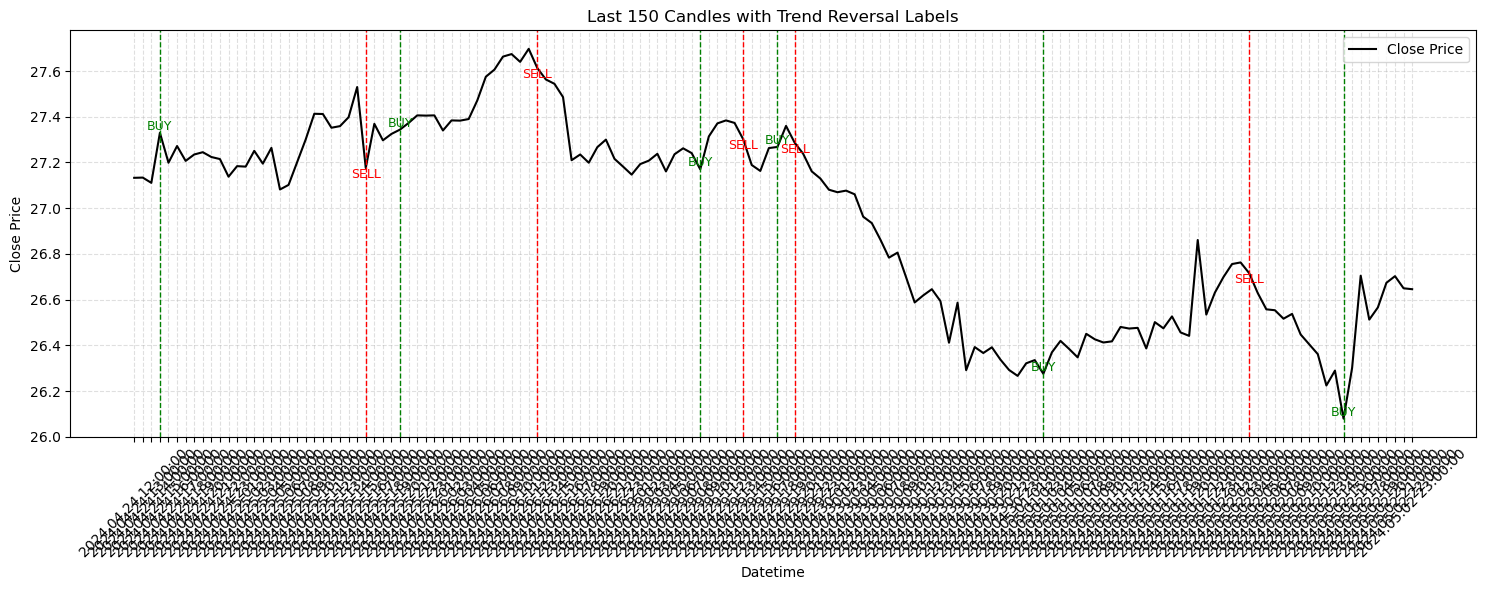

In [16]:
plot_labeled_candles(df)

In [17]:
# 3- Prepare Sequences
# Constants
INPUT_WINDOW = 60   # past 60 candles
FORECAST_HORIZON = 10  # predict next 10 reversal points
NUM_CLASSES = 3     # [0: no reversal, 1: buy, 2: sell]

# Ensure data is scaled and labeled already
features = scaled_data
labels = df['Label'].values

# Create sequences and labels
X, y = [], []

for i in range(len(features) - INPUT_WINDOW - FORECAST_HORIZON + 1):
    X.append(features[i:i+INPUT_WINDOW])
    y.append(labels[i+INPUT_WINDOW:i+INPUT_WINDOW+FORECAST_HORIZON])

X = np.array(X)  # Shape: (samples, 60, features)
y = np.array(y)  # Shape: (samples, 10)

# Convert labels to categorical (multi-class)
y_cat = to_categorical(y, num_classes=NUM_CLASSES)  # Shape: (samples, 10, 3)

# Split data



In [18]:
# 4- Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.1, random_state=42)

In [19]:
# 5- One-hot encode each timestep's class (3 classes → depth = 3)


In [22]:
# 7- Compile the Model (Handle Class Imbalance)
# Calculate class weights for labels 1 and 2
from sklearn.utils.class_weight import compute_class_weight

# Flatten the true class labels for class weight calculation
flat_labels = np.argmax(y_train, axis=-1).flatten()
class_weights_raw = compute_class_weight(class_weight='balanced', classes=np.arange(NUM_CLASSES), y=flat_labels)

# Convert to dictionary
from sklearn.utils.class_weight import compute_class_weight

flat_labels = np.argmax(y_train, axis=-1).flatten()
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(NUM_CLASSES),
    y=flat_labels
)

print("Class Weights Array:", class_weights_array)  # [w0, w1, w2]

# Use custom loss with class weights
import tensorflow.keras.backend as K

def weighted_categorical_crossentropy(weights_array):
    weights_tensor = K.constant(weights_array)

    def loss(y_true, y_pred):
        y_true = K.cast(y_true, tf.float32)
        y_pred = K.clip(y_pred, 1e-7, 1.0)  # numerical stability
        log_preds = K.log(y_pred)
        weighted_log_preds = y_true * log_preds * weights_tensor
        return -K.mean(K.sum(weighted_log_preds, axis=-1))

    return loss

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=weighted_categorical_crossentropy(class_weights_array),
    metrics=['accuracy']
)



Class Weights Array: [0.36233825 8.33114589 8.32526231]


In [23]:
# 8- Fit model

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
rc = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[es, rc],
    verbose=1
)
# shuffle=False,  # Important: keep time order! ?????


Epoch 1/50


I0000 00:00:1754634743.534527    8823 cuda_dnn.cc:529] Loaded cuDNN version 91001


774/774 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.3166 - loss: 1.1003 - val_accuracy: 0.2032 - val_loss: 1.0950 - learning_rate: 0.0010
Epoch 2/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.3039 - loss: 1.0975 - val_accuracy: 0.3040 - val_loss: 1.0944 - learning_rate: 0.0010
Epoch 3/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.3063 - loss: 1.0966 - val_accuracy: 0.3039 - val_loss: 1.0943 - learning_rate: 0.0010
Epoch 4/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.2998 - loss: 1.0928 - val_accuracy: 0.0443 - val_loss: 1.0942 - learning_rate: 0.0010
Epoch 5/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.1982 - loss: 1.1019 - val_accuracy: 0.4810 - val_loss: 1.0943 - learning_rate: 0.0010
Epoch 6/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.3410 - loss: 1.1013 - val_accuracy: 0.2167 - val_loss: 1.0943 - learning_rate: 0.0010
Epoch 7/50
772/774 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3273 - loss: 1.0967


In [24]:
# 9- Load the last 60 candles from a CSV file

# Load and clean
input_df = pd.read_csv('datasets-26/new-data-for-test/rows-60-from-20240503/rows-60-from-20240503.csv', sep='\t')
input_df.dropna(inplace=True)

input_df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# Add datetime
input_df['DATETIME'] = pd.to_datetime(input_df['DATE'] + ' ' + input_df['TIME'])

# Scale
input_features = input_df[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']]
input_scaled = scaler.transform(input_features)
input_sequence = np.expand_dims(input_scaled, axis=0)  # (1, 60, 5)

# Predict
pred_probs = model.predict(input_sequence)  # shape: (1, 10, 3)
pred_classes = np.argmax(pred_probs[0], axis=1)
print("Predicted Classes:", pred_classes)  # 0=no signal, 1=buy, 2=sell

# Timestamps for forecast
last_timestamp = input_df['DATETIME'].iloc[-1]
forecast_datetimes = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1),
                                   periods=FORECAST_HORIZON, freq='h')

# Output DataFrame
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')

print(predicted_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Predicted Classes: [1 1 1 2 2 1 1 2 2 1]
             DATETIME  forecast_class label
0 2024-05-07 15:00:00               1   buy
1 2024-05-07 16:00:00               1   buy
2 2024-05-07 17:00:00               1   buy
3 2024-05-07 18:00:00               2  sell
4 2024-05-07 19:00:00               2  sell
5 2024-05-07 20:00:00               1   buy
6 2024-05-07 21:00:00               1   buy
7 2024-05-07 22:00:00               2  sell
8 2024-05-07 23:00:00               2  sell
9 2024-05-08 00:00:00               1   buy


# plot section

In [25]:
# 10- Plot section

import sys

sys.path.insert(1, '../utils')
import forex_plot_utils
import os
import pandas as pd

# 10-1 PARAMETERS
csv1_path = 'datasets-26/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-26/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Write a suitable title.'
output_plot_path = None  # e.g., 'output.png'

# 10-2 LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None
# 10-3 Generate forecast timestamps ===
# Start 1 hour after the last actual candle
last_timestamp = input_df['DATETIME'].iloc[-1]
forecast_datetimes = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=FORECAST_HORIZON, freq='h')

# 10-4 Create predicted_df with forecasted trend reversals
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})


# 10-5 Optional: Add labels for plotting
def class_to_label(c):
    if c == 1:
        return 'buy'
    elif c == 2:
        return 'sell'
    else:
        return None


predicted_df['label'] = predicted_df['forecast_class'].apply(class_to_label)


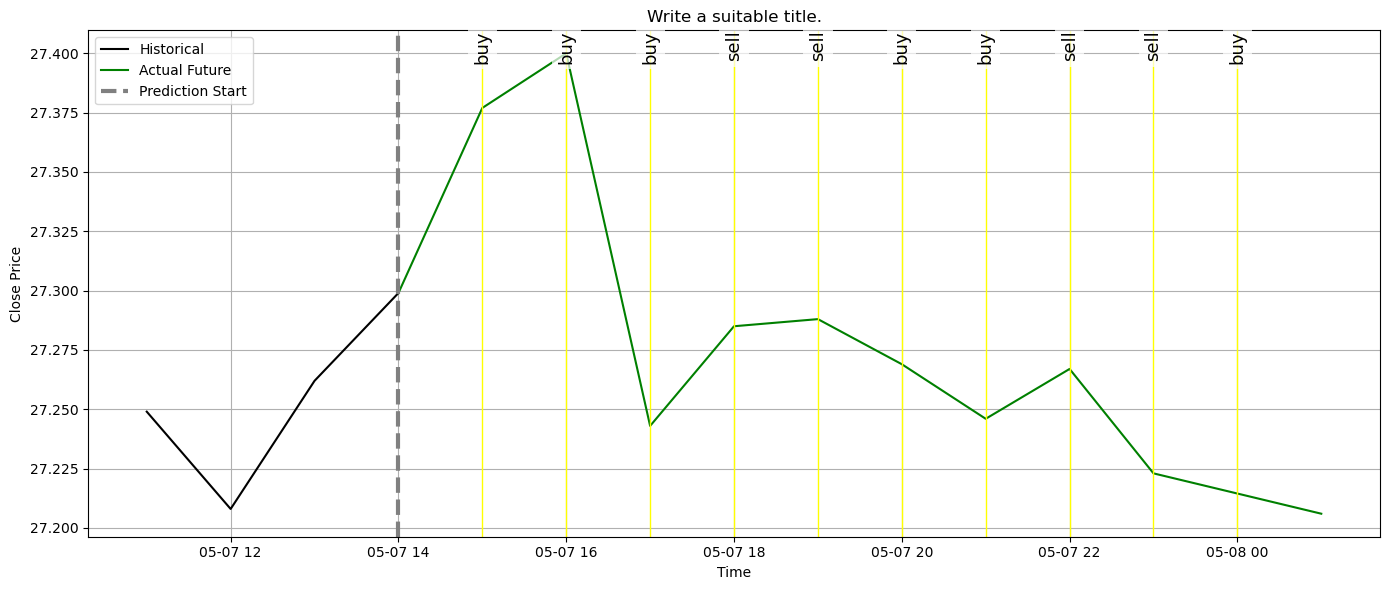

In [26]:
# 10-6 PLOT

forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [29]:
# 11- Save Model

from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
model.save(model_path)

# 11-4 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# 11-5 Save training loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# 11-6 Save model summary and final performance
y_test_onehot = to_categorical(y_test, num_classes=3)

with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_accuracy, final_test_mae = model.evaluate(X_test, y_test_onehot, verbose=0)

    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test Accuracy: {final_test_accuracy:.6f}\n')

NameError: name 'y_test' is not defined